## 1. Load and preprocess the text

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

text = open('bible.txt', 'rb').read().decode(encoding='utf-8').lower()
text[:250]

'1:1 in the beginning god created the heaven and the earth.\r\n\r\n1:2 and the earth was without form, and void; and darkness was upon\r\nthe face of the deep. and the spirit of god moved upon the face of the\r\nwaters.\r\n\r\n1:3 and god said, let there be light'

In [2]:
# remove \n and \r
text = text.replace('\r', '').replace('\n', ' ')
text[:250]

'1:1 in the beginning god created the heaven and the earth.  1:2 and the earth was without form, and void; and darkness was upon the face of the deep. and the spirit of god moved upon the face of the waters.  1:3 and god said, let there be light: and '

In [3]:
# remover the paragaphs numbers
import re
pattern = r'[0-9]+:[0-9]+'
text = re.sub(pattern, '', text)[1:].replace('   ', ' ').replace('  ', ' ')
text[:250]

'in the beginning god created the heaven and the earth. and the earth was without form, and void; and darkness was upon the face of the deep. and the spirit of god moved upon the face of the waters. and god said, let there be light: and there was ligh'

In [4]:
# remove punctutation
text = re.sub(r'[^\w\s]', '', text)
text[:250]

'in the beginning god created the heaven and the earth and the earth was without form and void and darkness was upon the face of the deep and the spirit of god moved upon the face of the waters and god said let there be light and there was light and g'

In [5]:
tokens = text.split(' ')
tokens = tokens[:500_000]

number_of_unique_tokens = len(set(tokens))

print('Total Tokens: %d' % len(tokens))
print('Unique Tokens: %d' % number_of_unique_tokens)

sequence_length = 3

# organize into sequences of tokens of input words plus one output word
length = sequence_length + 1
sequences = list()
for i in range(length, len(tokens)):
    # select sequence of tokens
    seq = tokens[i-length:i]
    # convert into a line
    line = ' '.join(seq)
    # store
    sequences.append(line)

print ('Total Sequences: %d' % len(sequences))
print ('This is the first sequence: {0}'.format(sequences[0]))
print ('This is the second sequence: {0}'.format(sequences[1]))
print ('This is the third sequence: {0}'.format(sequences[2]))

Total Tokens: 500000
Unique Tokens: 10071
Total Sequences: 499996
This is the first sequence: in the beginning god
This is the second sequence: the beginning god created
This is the third sequence: beginning god created the


## 2. Train the model

In [6]:
from keras.preprocessing.text import Tokenizer
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM, Dropout
from keras.layers import Embedding
 
tokenizer = Tokenizer()
tokenizer.fit_on_texts(sequences)
sequences = tokenizer.texts_to_sequences(sequences)

# remove sequences with not enough words
sequences = [sequences[i] for i in range(len(sequences)) if len(sequences[i])==length]

vocab_size = number_of_unique_tokens + 1
 
sequences0 = np.array(sequences)
X, y = sequences0[:,:-1], sequences0[:,-1]
y = to_categorical(y, num_classes=vocab_size)

Epoch 1/50
2926/2926 [==============================] - 139s 44ms/step - loss: 6.0947 - accuracy: 0.0889 - val_loss: 5.7889 - val_accuracy: 0.1284
Epoch 2/50
2926/2926 [==============================] - 110s 38ms/step - loss: 5.6455 - accuracy: 0.1500 - val_loss: 5.3998 - val_accuracy: 0.1725
Epoch 3/50
2926/2926 [==============================] - 111s 38ms/step - loss: 5.3673 - accuracy: 0.1728 - val_loss: 5.2157 - val_accuracy: 0.1844
Epoch 4/50
2926/2926 [==============================] - 113s 39ms/step - loss: 5.2013 - accuracy: 0.1834 - val_loss: 5.1097 - val_accuracy: 0.1931
Epoch 5/50
2926/2926 [==============================] - 134s 46ms/step - loss: 5.0926 - accuracy: 0.1886 - val_loss: 5.0349 - val_accuracy: 0.1960
Epoch 6/50
2926/2926 [==============================] - 160s 55ms/step - loss: 5.0121 - accuracy: 0.1915 - val_loss: 4.9867 - val_accuracy: 0.1985
Epoch 7/50
2926/2926 [==============================] - 155s 53ms/step - loss: 4.9473 - accuracy: 0.1948 - val_loss: 4

INFO:tensorflow:Assets written to: bible_model\assets


INFO:tensorflow:Assets written to: bible_model\assets


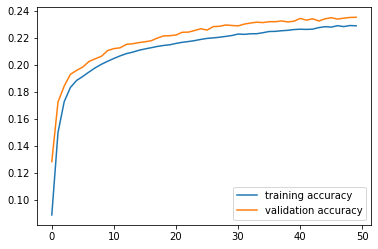

In [7]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

# The learned embedding needs to know how many dimensions will be used to represent each word. 
# That is, the size of the embedding vector space. That is, the size of the embedding vector space.
# Common values are 50, 100, and 300. Consider testing smaller or larger values.
dimensions_to_represent_word = 100
 
model = Sequential()
model.add(Embedding(vocab_size, sequence_length, input_length=sequence_length))
# We will use a two LSTM hidden layers with 100 memory cells each. 
# More memory cells and a deeper network may achieve better results.
model.add(LSTM(100, return_sequences=True))
model.add(LSTM(100))
model.add(Dense(50, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(vocab_size, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Training may take a few hours on modern hardware without GPUs. 
# You can speed it up with a larger batch size and/or fewer training epochs.
history = model.fit(
    X_train, 
    y_train, 
    batch_size=128, 
    epochs=50, 
    verbose=1,
    validation_data=(X_test, y_test)
)

plt.plot(history.history['accuracy'], label='training accuracy')
plt.plot(history.history['val_accuracy'], label='validation accuracy')
plt.legend()


model.save('bible_model')

## 3. Predict word by word

In [8]:
# must be longer than sequence_length
seed = "the twelve sons of"
n_predictions = 15
reverse_word_map = dict(map(reversed, tokenizer.word_index.items()))

print('seed : \n' + seed)
last_words = seed.split(' ')[-sequence_length:]
preds = []

for i in range(n_predictions):
    example = tokenizer.texts_to_sequences([last_words])
    prediction = model.predict(np.array(example), verbose=0)
    predicted_word = np.argmax(prediction)
    last_words = last_words[1:]
    last_words.append(reverse_word_map[predicted_word])
    preds.append(reverse_word_map[predicted_word])
    
print('next words : \n' + ' '.join(preds))

seed : 
the twelve sons of
next words : 
the lord and the lord said unto moses i will not be the lord and


In [9]:
'safety' in tokenizer.word_index.keys()

True